# Assignment 1.1 : Conservative Variables. 

In [1]:
import numpy as np
import scipy.linalg as la
from scipy import stats
from scipy.interpolate import interp1d
import scipy
import time
import scipy.io
from scipy.sparse import diags
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import copy
import cv2
from matplotlib.patches import Circle


import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

In [2]:
mat = scipy.io.loadmat('matlab_files/supersonicJetLES_xyPlane.mat')

In [3]:
# temp
T = mat["T"]
# density 
rho = mat["rho"]
# velocity in x direction. 
u = mat["u"]
# velocity in y direction. 
v = mat["v"]
# x computational grid. 
xx = mat["xx"]
# y computational grid. 
yy = mat["yy"]
print(xx.shape)
print(yy.shape)

(300, 75)
(300, 75)


In [4]:
# paramaters. 
cp = 1005
cv = 718
R = cp- cv
mu0 = 1.735 * 1e-5
S1 = 110.4
T0 = np.mean(T)

In [5]:
def prim2cons(rho, u, v, T, cv):
    return np.array([rho, rho*u, rho*v, rho*(cv*T + 0.5*(u**2 + v**2))])

In [6]:
def cons2prim(U, R, cv):
    rho = U[0]
    u = U[1]/U[0]
    v = U[2]/U[0] 
    Et = U[3]
    e = U[3]/U[0] - 0.5*(u**2 + v**2)
    T = e/cv
    p = rho*R*T
    return np.array([rho, u, v, T, p, e, Et])

In [7]:
def sutherland(T, mu0):
    return mu0*((T/T0)**(3/2)) * ((T0 + S1)/(T + S1))

In [8]:
mu = sutherland(T, mu0)

In [9]:
U = prim2cons(rho, u, v, T, cv)

In [10]:
rho_n, u_n, v_n, T_n, p, e, Et = cons2prim(U, R, cv)

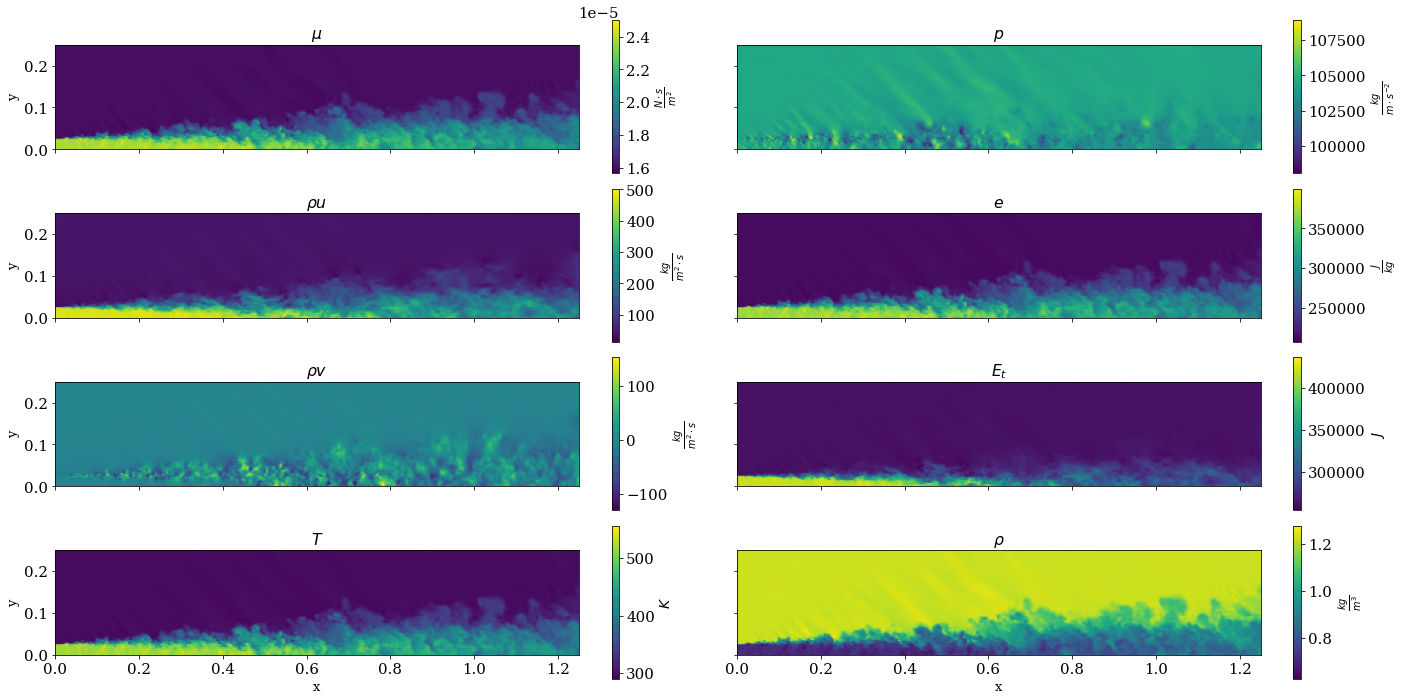

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(20, 10))
pos = ax[0,0].pcolormesh(xx, yy, mu, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[0, 0])
cbar.ax.set_ylabel(r'$\frac{N \cdot s}{m^2}$', rotation=90, fontsize=14)
ax[0,0].set_ylabel("y")
ax[0,0].set_aspect('equal', 'box')
ax[0, 0].set_title(r"$\mu$")


pos = ax[1,0].pcolormesh(xx, yy, rho*u, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[1, 0])
cbar.ax.set_ylabel(r'$\frac{kg}{m^2 \cdot s}$', rotation=90, fontsize=14)
ax[1,0].set_ylabel("y")
ax[1,0].set_aspect('equal', 'box')
ax[1, 0].set_title(r"$\rho u$")

pos = ax[2,0].pcolormesh(xx, yy, rho*v, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[2, 0])
cbar.ax.set_ylabel(r'$\frac{kg}{m^2 \cdot s}$', rotation=90, fontsize=14)
ax[2,0].set_ylabel("y")
ax[2,0].set_aspect('equal', 'box')
ax[2, 0].set_title(r"$\rho v$")

pos = ax[3,0].pcolormesh(xx, yy, T, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[3, 0])
cbar.ax.set_ylabel(r'$K$', rotation=90, fontsize=14)
ax[3,0].set_xlabel("x")
ax[3,0].set_ylabel("y")
ax[3,0].set_aspect('equal', 'box')
ax[3, 0].set_title(r"$T$")

pos = ax[0,1].pcolormesh(xx, yy, p, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[0,1])
cbar.ax.set_ylabel(r'$\frac{kg}{m \cdot s^{-2}}$', rotation=90, fontsize=14)
ax[0,1].set_aspect('equal', 'box')
ax[0,1].set_title(r"$p$")

pos = ax[1,1].pcolormesh(xx, yy, e, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[1,1])
cbar.ax.set_ylabel(r'$\frac{J}{kg}$', rotation=90, fontsize=14)
ax[1,1].set_aspect('equal', 'box')
ax[1,1].set_title(r"$e$")

pos = ax[2,1].pcolormesh(xx, yy, Et, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[2,1])
cbar.ax.set_ylabel(r'$J$', rotation=90, fontsize=14)
ax[2,1].set_aspect('equal', 'box')
ax[2,1].set_title(r"$E_{t}$")

pos = ax[3,1].pcolormesh(xx, yy, rho, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[3,1])
cbar.ax.set_ylabel(r'$\frac{kg}{m^3}$', rotation=90, fontsize=14)
ax[3,1].set_xlabel("x")
ax[3,1].set_aspect('equal', 'box')
ax[3,1].set_title(r"$\rho$")

plt.tight_layout()
plt.savefig("jet/subplots.png", dpi=600)

# Assignment 3.2: Stressed out

In [42]:
def ddx_fwd(f, dx):
    # return the first erivative of f in x using a 
    # first-order forward difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == f.shape[0] -1:
                df[ii, jj] = (f[ii, jj] - f[ii -1, jj])/dx
            else:
                df[ii, jj] = (f[ii + 1, jj] - f[ii, jj])/dx
    return df

def ddx_bwd(f, dx):
    # return the first erivative of f in x using a 
    # first-order backward difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == 0:
                df[ii, jj] = (f[ii+1, jj] - f[ii, jj])/dx
            else:
                df[ii, jj] = (f[ii, jj] - f[ii -1, jj])/dx
    return df

def d2dx2(f, dx):
    # return the first erivative of f in x using a 
    # first-order central difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == 0:
                df[ii, jj] = (2*f[ii, jj] -5*f[ii + 1, jj] +4* f[ii+2, jj] - f[ii + 3, jj])/(dx**2)
            elif ii == f.shape[0] -1:
                df[ii, jj] = (2*f[ii, jj] -5*f[ii - 1, jj] + 4*f[ii-2, jj] - f[ii-3, jj])/(dx**2)
            else:
                df[ii, jj] = (f[ii+1, jj] - 2*f[ii, jj] + f[ii -1, jj])/(dx**2)
    return df

In [44]:
def ddx_central(f, dx):
    # return the first erivative of f in x using a 
    # first-order central difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == 0:
                df[ii, jj] = (-3*f[ii, jj] +4*f[ii + 1, jj] - f[ii+2, jj])/(2*dx)
            elif ii == f.shape[0] -1:
                df[ii, jj] = (3*f[ii, jj] -4*f[ii - 1, jj] + f[ii-2, jj])/(2*dx)
            else:
                df[ii, jj] = (f[ii+1, jj] - f[ii -1, jj])/(2*dx)
    return df

In [128]:
dx = xx[1, 0] - xx[0, 0]
dy = yy[0, 1] - yy[0, 0]

In [130]:
dudx = ddx_fwd(u, dx)
dudy = ddx_central(u.T, dy).T
dvdy = ddx_central(v.T, dy).T
dvdx = ddx_fwd(v, dx)

tau_xx = 2*mu*(dudx - 1/3*(dudx + dvdy))
tau_yy = 2*mu*(dvdy - 1/3*(dudx + dvdy))
tau_xy = mu*(dudy + dvdx)




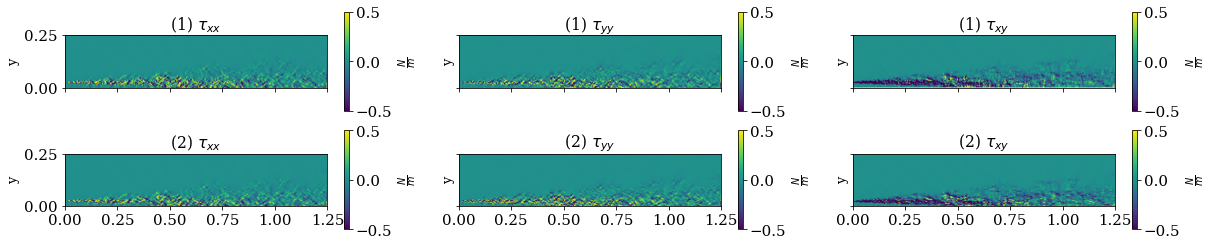

In [131]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20,4))
dudx = ddx_fwd(u, dx)
dudy = ddx_central(u.T, dy).T
dvdy = ddx_central(v.T, dy).T
dvdx = ddx_fwd(v, dx)

tau_xx = 2*mu*(dudx - 1/3*(dudx + dvdy))
tau_yy = 2*mu*(dvdy - 1/3*(dudx + dvdy))
tau_xy = mu*(dudy + dvdx)
pos = ax[0,0].pcolormesh(xx, yy, tau_xx,  vmin=-0.5, vmax=0.5,shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[0, 0])
cbar.ax.set_ylabel(r'$\frac{N}{m}$', rotation=90, fontsize=14)
ax[0,0].set_ylabel("y")
ax[0,0].set_aspect('equal', 'box')
ax[0, 0].set_title(r"(1) $\tau_{xx}$")

pos = ax[0, 1].pcolormesh(xx, yy, tau_yy, vmin=-0.5, vmax=0.5,shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[0, 1])
cbar.ax.set_ylabel(r'$\frac{N}{m}$', rotation=90, fontsize=14)
ax[0, 1].set_ylabel("y")
ax[0, 1].set_aspect('equal', 'box')
ax[0, 1].set_title(r"(1) $\tau_{yy}$")

pos = ax[0, 2].pcolormesh(xx, yy, tau_xy,vmin=-0.5, vmax=0.5, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[0, 2])
cbar.ax.set_ylabel(r'$\frac{N}{m}$', rotation=90, fontsize=14)
ax[0, 2].set_ylabel("y")
ax[0, 2].set_aspect('equal', 'box')
ax[0, 2].set_title(r"(1) $\tau_{xy}$")


dudx = ddx_central(u, dx)
dudy = ddx_fwd(u.T, dy).T
dvdy = ddx_fwd(v.T, dy).T
dvdx = ddx_central(v, dx)

tau_xx = 2*mu*(dudx - 1/3*(dudx + dvdy))
tau_yy = 2*mu*(dvdy - 1/3*(dudx + dvdy))
tau_xy = mu*(dudy + dvdx)

pos = ax[1,0].pcolormesh(xx, yy, tau_xx,vmin=-0.5, vmax=0.5, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[1,0])
cbar.ax.set_ylabel(r'$\frac{N}{m}$', rotation=90, fontsize=14)
ax[1,0].set_ylabel("y")
ax[1,0].set_aspect('equal', 'box')
ax[1,0].set_title(r"(2) $\tau_{xx}$")

pos = ax[1,1].pcolormesh(xx, yy, tau_yy, vmin=-0.5, vmax=0.5,shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[1,1])
cbar.ax.set_ylabel(r'$\frac{N}{m}$', rotation=90, fontsize=14)
ax[1,1].set_ylabel("y")
ax[1,1].set_aspect('equal', 'box')
ax[1,1].set_title(r"(2) $\tau_{yy}$")

pos = ax[1,2].pcolormesh(xx, yy, tau_xy, vmin=-0.5, vmax=0.5, shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[1,2])
cbar.ax.set_ylabel(r'$\frac{N}{m}$', rotation=90, fontsize=14)
ax[1,2].set_ylabel("y")
ax[1,2].set_aspect('equal', 'box')
ax[1,2].set_title(r"(2) $\tau_{xy}$")

plt.savefig("jet/stressed_out.png", dpi=600)

# Assignment 3.3: MacCormack for Burgers

In [132]:
mat = scipy.io.loadmat('matlab_files/gotritons_uv.mat')

In [133]:
u = mat["u"]
v = mat["v"]
xx = mat["xx"]
yy = mat["yy"]
dx = xx[1, 0] - xx[0, 0]
dy = yy[0, 1] - yy[0, 0]

u.shape
v.shape
xx.shape
yy.shape

(400, 200)

In [134]:
# diffusion coefficient 
d = 0.0005

In [135]:
vmax = np.max(np.abs(v))
umax = np.max(np.abs(u))

dt = 1e-3
print(umax*dt/dx + vmax*dt/dy)
print(int(2/dt))
t = np.linspace(0, 2, int(2/dt))

0.399
2000


In [114]:
def ddx_fwd(f, dx):
    # return the first derivative of f in x using a 
    # first-order forward difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == f.shape[0] -1:
                df[ii, jj] = (f[0, jj] - f[ii, jj])/dx
            else:
                df[ii, jj] = (f[ii + 1, jj] - f[ii, jj])/dx
    return df

def ddx_bwd(f, dx):
    # return the first derivative of f in x using a 
    # first-order backward difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == 0:
                df[ii, jj] = (f[ii, jj] - f[-1, jj])/dx
            else:
                df[ii, jj] = (f[ii, jj] - f[ii - 1, jj])/dx
    return df

def d2dx2(f, dx):
    # return the first derivative of f in x using a 
    # first-order central difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == 0:
                df[ii, jj] = (f[ii+1, jj] - 2*f[ii, jj] + f[-1, jj])/(dx**2)
            elif ii == f.shape[0] -1:
                df[ii, jj] = (f[0, jj] - 2*f[ii, jj] + f[ii -1, jj])/(dx**2)
            else:
                df[ii, jj] = (f[ii+1, jj] - 2*f[ii, jj] + f[ii -1, jj])/(dx**2)
    return df

def ddy_fwd(f, dx):
    # return the first erivative of f in x using a 
    # first-order forward difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == f.shape[0] -1:
                df[ii, jj] = (f[ii, jj] - f[ii -1, jj])/dx
            else:
                df[ii, jj] = (f[ii + 1, jj] - f[ii, jj])/dx
    return df

def ddy_bwd(f, dx):
    # return the first erivative of f in x using a 
    # first-order backward difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == 0:
                df[ii, jj] = (f[ii+1, jj] - f[ii, jj])/dx
            else:
                df[ii, jj] = (f[ii, jj] - f[ii -1, jj])/dx
    return df

def d2dy2(f, dx):
    # return the first erivative of f in x using a 
    # first-order central difference. 
    df = np.zeros(f.shape)
    for jj in range(f.shape[1]):
        for ii in range(f.shape[0]):
            if ii == 0:
                df[ii, jj] = (2*f[ii, jj] -5*f[ii + 1, jj] +4* f[ii+2, jj] - f[ii + 3, jj])/(dx**2)
            elif ii == f.shape[0] -1:
                df[ii, jj] = (2*f[ii, jj] -5*f[ii - 1, jj] + 4*f[ii-2, jj] - f[ii-3, jj])/(dx**2)
            else:
                df[ii, jj] = (f[ii+1, jj] - 2*f[ii, jj] + f[ii -1, jj])/(dx**2)
    return df

In [275]:
def burgers_maccormack(u, v, dx, dy, dt):
    u_next = np.zeros(u.shape)
    v_next = np.zeros(v.shape)
    u_temp = np.zeros(u.shape)
    v_temp = np.zeros(v.shape)
    
    
    dudx = ddx_fwd(u, dx)
    dvdx = ddx_fwd(v, dx) 
    dudy = ddy_fwd(u.T, dy).T
    dvdy = ddy_fwd(v.T, dy).T
    du2dx2 = d2dx2(u, dx)
    du2dy2 = d2dy2(u.T, dy).T
    dv2dx2 = d2dx2(v, dx)
    dv2dy2 = d2dy2(v.T, dy).T
    
    # predictor step 
    u_temp = u - dt*u*dudx - dt*v*dudy + dt*d*(du2dx2 + du2dy2)
    v_temp = v - dt*u*dvdx - dt*v*dvdy + dt*d*(dv2dx2 + dv2dy2)
    
    u_temp[:, 0] = np.zeros(u.shape[0])
    u_temp[:, -1] = np.zeros(u.shape[0])
    v_temp[:, 0] = np.zeros(u.shape[0])
    v_temp[:, -1] = np.zeros(u.shape[0])
    
    
    dutdx = ddx_bwd(u_temp, dx)
    dvtdx = ddx_bwd(v_temp, dx) 
    dutdy = ddy_bwd(u_temp.T, dy).T
    dvtdy = ddy_bwd(v_temp.T, dy).T
    dut2dx2 = d2dx2(u_temp, dx)
    dut2dy2 = d2dy2(u_temp.T, dy).T
    dvt2dx2 = d2dx2(v_temp, dx)
    dvt2dy2 = d2dy2(v_temp.T, dy).T
    
    # corrector step. 
    u_next = 0.5*(u + u_temp -dt*u_temp*dutdx -dt*v_temp*dutdy +  d*dt*(dut2dx2 + dut2dy2))
    v_next = 0.5*(v + v_temp -dt*u_temp*dvtdx -dt*v_temp*dvtdy +  d*dt*(dvt2dx2 + dvt2dy2))
                  
    return u_next, v_next

In [276]:
u_sol = np.zeros((u.shape[0], u.shape[1], len(t)))
v_sol = np.zeros((u.shape[0], u.shape[1], len(t)))
u_sol[:, :, 0] = u
v_sol[:, :, 0] = v

tol_t = 0

for ii in range(10**3):
    dt = 0.9/(np.max(np.abs(u_sol[:, :, ii]))/dx + np.max(np.abs(v_sol[:, :, ii]))/dy)
    if tol_t + dt >= 2:
        dt = 2 - tol_t
    
    tol_t += dt
    u_sol[:, :, ii+1], v_sol[:, :, ii+1] = burgers_maccormack(u_sol[:, :, ii], v_sol[:, :, ii], dx, dy, dt) 
    
    if ii % 50 == 0:
        print(tol_t)
        
    if tol_t >= 2:
        break

0.002255639097744361
0.11496636175130202
0.22782051513769616
0.3409661073976459
0.4553817773954067
0.5709357983817529
0.6879081054698906
0.8061556518523979
0.924973418396363
1.0445311576678007
1.1652373909795897
1.2877725241278142
1.412493827009732
1.5394331222550053
1.6685062990731108
1.7996137545253206
1.932654569135509


In [277]:
u_f = u_sol[:, :, ii]
v_f = v_sol[:, :, ii]

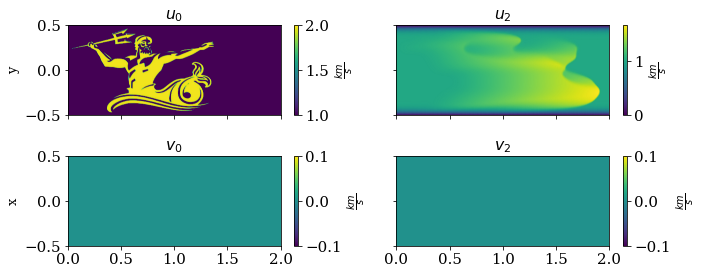

In [278]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,4))

pos = ax[0,0].pcolormesh(xx, yy, u,shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[0, 0])
cbar.ax.set_ylabel(r'$\frac{km}{s}$', rotation=90, fontsize=14)
ax[0,0].set_ylabel("y")
#ax[0,0].set_aspect('equal', 'box')
ax[0, 0].set_title(r"$u_{0}$")

pos = ax[1,0].pcolormesh(xx, yy, v ,shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[1, 0])
cbar.ax.set_ylabel(r'$\frac{km}{s}$', rotation=90, fontsize=14)
ax[1,0].set_ylabel("y")
ax[1,0].set_ylabel("x")
#ax[1,0].set_aspect('equal', 'box')
ax[1, 0].set_title(r"$v_{0}$")

pos = ax[0,1].pcolormesh(xx, yy,  u_f,shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[0, 1])
cbar.ax.set_ylabel(r'$\frac{km}{s}$', rotation=90, fontsize=14)
#ax[0,1].set_aspect('equal', 'box')
ax[0,1].set_title(r"$u_{2}$")

pos = ax[1,1].pcolormesh(xx, yy, v_f ,shading='gouraud')
cbar = fig.colorbar(pos, ax=ax[1, 1])
cbar.ax.set_ylabel(r'$\frac{km}{s}$', rotation=90, fontsize=14)
#ax[1,1].set_aspect('equal', 'box')
ax[1,1].set_title(r"$v_{2}$")


plt.tight_layout()
plt.savefig("jet/burgers_maccormack.png", dpi=600)

In [ ]:
ii

In [ ]:
plt.imshow(u)